# Processing Kim 2019
Processing library on library screen from [Kim et al. 2019](https://advances.sciencemag.org/content/5/11/eaax9249)

Library Design: For the target sequences for the oligonucleotide pool, we extracted sequences from the human genome and
generated random synthetic sequences without any information about the activity of the corresponding sgRNAs.
We first randomly extracted 9824 target sequences from the GeCKOv1 library (40),
excluding those with BsmBI sites in their sequences. From 1841 target sequences from the coding sequences of three
human and six mouse cell surface marker–encoding genes (14) and 2549 sequences from genes related to
resistance against vemurafenib, selumetinib, and 6-thioguanine (7),
we obtained 1804 and 2484 target sequences, respectively, after excluding sequences containing BsmBI sites.
For training the algorithm with guide sequences with extreme GC content, we randomly generated synthetic input sequences
containing an NGG PAM with a total length of 30 nt using in-house Python scripts (Supplementary Code) and
subsequently selected 998 input sequences containing guide sequences with extremely low or high GC content (≤20% or ≥80%).
In addition, 546 endogenous target sequences from human coding and noncoding genes of interest designed for other
studies in our laboratory were included; for this group, five unique barcodes per target sequence were used to yield
fivefold coverage for each target site. Together, the set of 17,840 oligonucleotides is composed of
9824 + (1804 + 2484) + 998 + (546 × 5) oligonucleotides.

### Data Filters
1. pdna or etp > mean pdna -3 std

In [1]:
import pandas as pd
import seaborn as sns
from poola import core as pool

from core import add_transform_col

In [2]:
kim_train = pd.read_csv('../data/raw/Kim2019_S1_Train.csv')
kim_test = pd.read_csv('../data/raw/Kim2019_S1_Test.csv')

In [3]:
clean_train = (kim_train
               .rename({'Target context sequence (4+20+3+3)': 'sgRNA Context Sequence', 
                        'Total read count (Day 0)': 'etp_reads', 
                        'Background subtracted indel (%)': 'indel_freq'}, axis=1)
               [['sgRNA Context Sequence', 'etp_reads', 'indel_freq']])
clean_train['sgRNA Sequence'] = clean_train['sgRNA Context Sequence'].str[4:24]
clean_train['etp_lognorm'] = pool.lognorm(clean_train['etp_reads'])
clean_test = (kim_test
              .dropna()
              .rename({'Target context sequence (4+20+3+3)': 'sgRNA Context Sequence', 
                       'Total read count (average, Day 0)': 'etp_reads', 
                       'Background subtracted indel frequencies\n(average, %)': 'indel_freq'}, axis=1)
              [['sgRNA Context Sequence', 'etp_reads', 'indel_freq']])
clean_test['sgRNA Sequence'] = clean_test['sgRNA Context Sequence'].str[4:24]
clean_test['etp_lognorm'] = pool.lognorm(clean_test['etp_reads'])

<AxesSubplot:xlabel='etp_lognorm', ylabel='Count'>

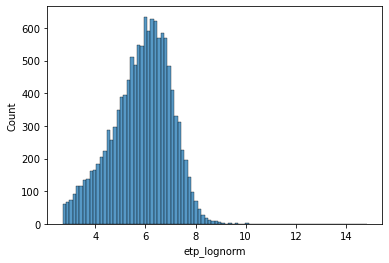

In [4]:
sns.histplot(clean_train['etp_lognorm'])

In [5]:
filtered_train = pool.filter_pdna(lognorm_df=clean_train, pdna_cols=['etp_lognorm'])
print('Train pDNA filtered: ' + str(clean_train.shape[0] - filtered_train.shape[0]))

Train pDNA filtered: 0


<AxesSubplot:xlabel='etp_lognorm', ylabel='Count'>

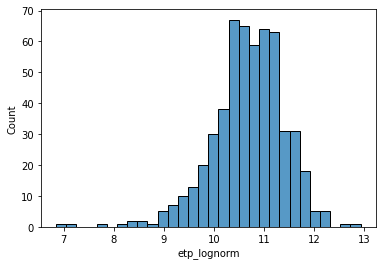

In [6]:
sns.histplot(clean_test['etp_lognorm'])

In [7]:
filtered_test = pool.filter_pdna(lognorm_df=clean_test, pdna_cols=['etp_lognorm'])
print('Test pDNA filtered: ' + str(clean_test.shape[0] - filtered_test.shape[0]))

Test pDNA filtered: 6


<AxesSubplot:xlabel='indel_freq', ylabel='Count'>

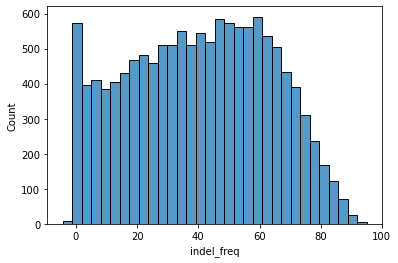

In [8]:
sns.histplot(filtered_train['indel_freq'])

<AxesSubplot:xlabel='indel_freq', ylabel='Count'>

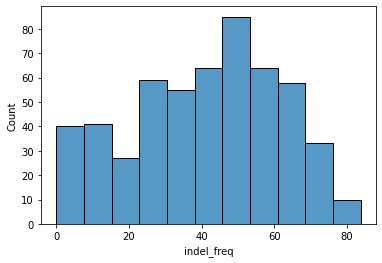

In [9]:
sns.histplot(filtered_test['indel_freq'])

In [10]:
print('Train Shape: ' + str(filtered_train.shape[0]))

Train Shape: 12832


In [11]:
print('Test Shape: ' + str(filtered_test.shape[0]))

Test Shape: 536


In [12]:
filtered_train = add_transform_col(df=filtered_train,
                                   col='indel_freq',
                                   transform_name='yeo-johnson',
                                   transformed_name='scaled_indels')
filtered_test = add_transform_col(df=filtered_test,
                                  col='indel_freq',
                                  transform_name='yeo-johnson',
                                  transformed_name='scaled_indels')

In [13]:
output_cols = ['sgRNA Context Sequence', 'sgRNA Sequence', 'scaled_indels']
filtered_train[output_cols].to_csv('../data/processed/Kim2019_train_activity.csv', index=False)
filtered_test[output_cols].to_csv('../data/processed/Kim2019_test_activity.csv', index=False)